# Restricted Boltzmann Machine - MNIST: 2503 group

<div style="display: flex; justify-content: center;">
  <table>
      <tr>
          <th>Nome e cognome </th>
          <th>Numero di matricola</th>
      </tr>
      <tr>
          <td>Marco Boscolo</td>
          <td>2157559</td>
      </tr>
      <tr>
          <td>Francesco La Rovere</td>
          <td>2164968</td>
      </tr>
      <tr>
          <td>Nicolò Montagner</td>
          <td>2165809</td>
      </tr>
      <tr>
          <td>Raffaele Sabatini</td>
          <td>2165739</td>
      </tr>
  </table>
</div>

In [1]:
import sys, datetime
import itertools as it
import scipy
import itertools
import tqdm
import os
import glob
from collections import Counter
import ast
import pandas as pd
import time
import numexpr as ne
import scipy.special

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# to load MNIST
from sklearn.datasets import fetch_openml

In [3]:
!mkdir SimpleTrain
!mkdir KFoldTrain
!mkdir RandomSearchTrain

mkdir: SimpleTrain: File exists
mkdir: KFoldTrain: File exists
mkdir: RandomSearchTrain: File exists


In [5]:
Folder1 = 'SimpleTrain'
Folder2 = 'KFoldTrain'
Folder3 = 'RandomSearchTrain'

In [6]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
print(X_original.shape)

(70000, 784)


In [7]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
D = 784
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

In [8]:
# Gradient descent options
GRAD_list = ["SGD", "RMSprop"]
GRAD = GRAD_list[1]
if GRAD == "SGD":
   l_rate_ini, l_rate_fin = 1.0, 0.25
if GRAD == "RMSprop":
   beta, epsilon = 0.9, 1e-4
   l_rate_ini, l_rate_fin = 0.05, 0.05
   print("epsilon=", epsilon)
gamma = 0.001  ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:", GRAD)
print(f"learning rate = {l_rate_ini} --> {l_rate_fin}")
if gamma != 0:
   print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate = 0.05 --> 0.05
gamma=0.001	regularization


('0', '1', '2')
first 10 MNIST data points


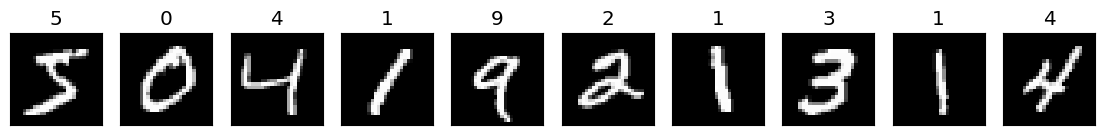

first 10 MNIST-3 data points


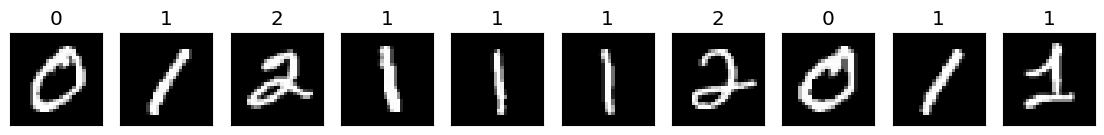

first 10 MNIST-3 data points, binarized


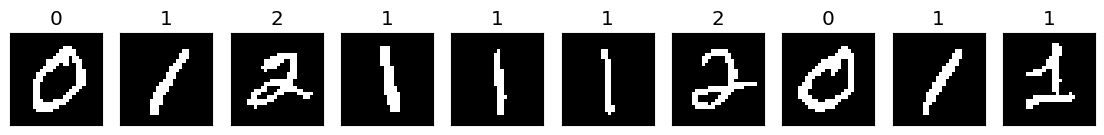

each of Nd=21770 data has D=784 bits


In [10]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side == 0:
        side = int(sqrt(x.shape[1]))
    if len(y) < 1:
        y = np.full(Nex, "")
    colors = np.array(colors)
    fig, AX = plt.subplots(1, Nex, figsize=(S * Nex, S))

    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors) == 0:
            newcmp = "grey"
        else:
            col = colors[0] + (colors[1] - colors[0]) * (i + 1) / (Nex + 1)
            newcmp = ListedColormap((col, (1, 1, 1, 1)))
        ax = AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y) > 0:
            ax.set_title(y[i])
        if len(z) > 0:
            ax.set_title("".join(map(str, z[i])), fontsize=9)
    plt.show()


def MNIST_bit(X, side=28, level=0.5):
    NX = len(X)
    # print(X.shape)
    # print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side == 14:
        X = np.reshape(X, (NX, 28, 28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25 * (
            X[:, 0::2, 0::2] + X[:, 1::2, 0::2] + X[:, 0::2, 1::2] + X[:, 1::2, 1::2]
        )
        X = Xr.reshape(NX, side**2)
    # print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X / 255 > level, 1, x_min)
    return X.astype("int")


list_10_digits = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep = np.isin(Y_original, list_digits)
X_keep, Y = X_original[keep], Y_original[keep]

data, label = MNIST_bit(X_keep), Y
data, label = data.astype("int"), label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original, Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label, Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label, Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D = len(data[1])

print(f"each of Nd={Nd} data has D={D} bits")

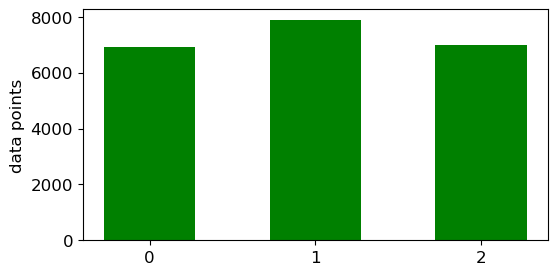

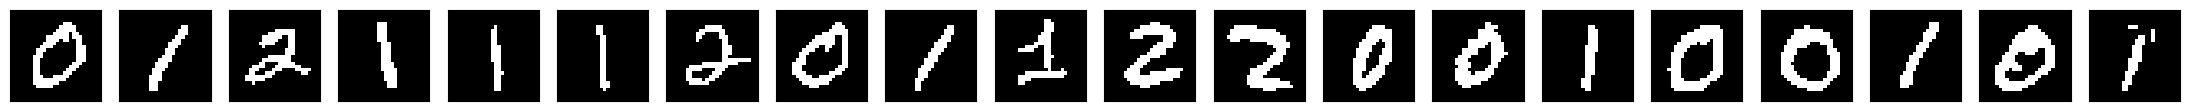

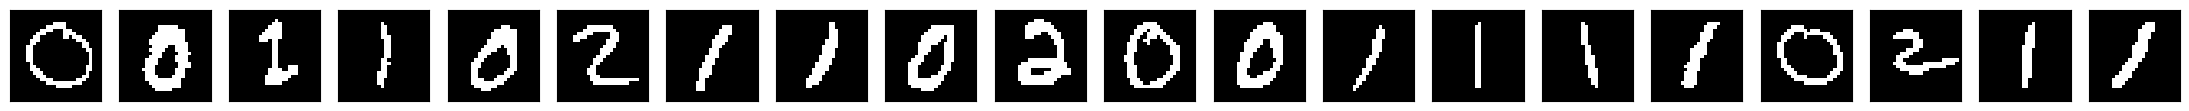

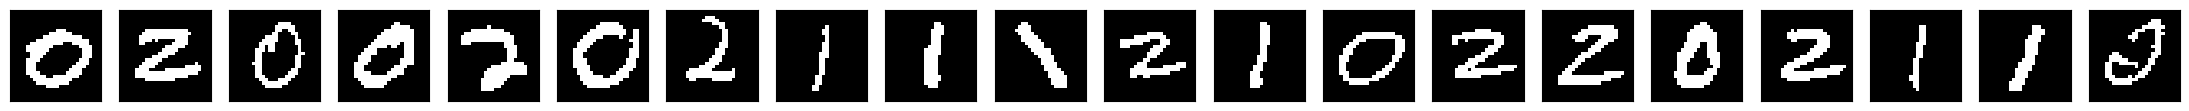

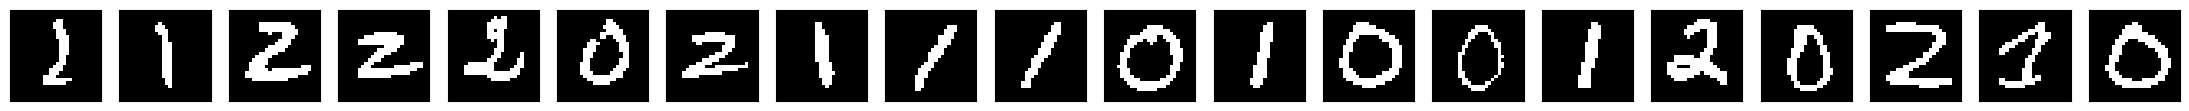

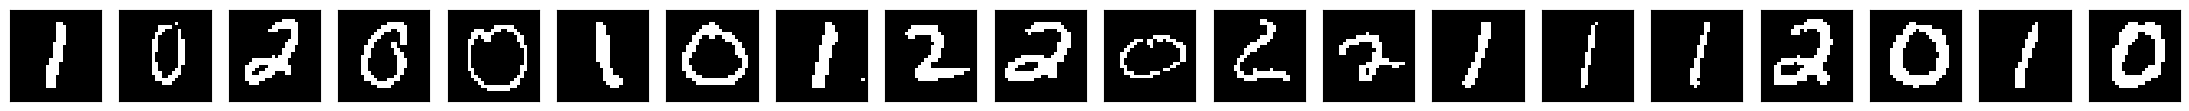

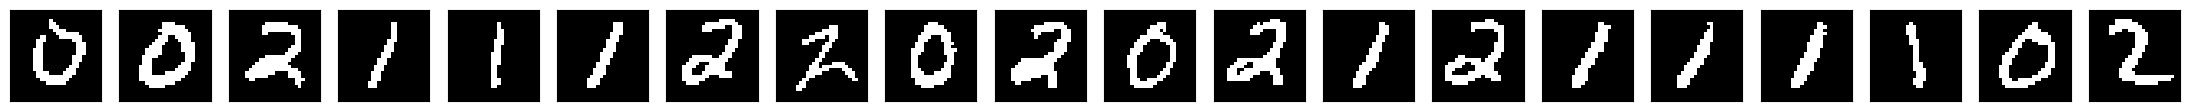

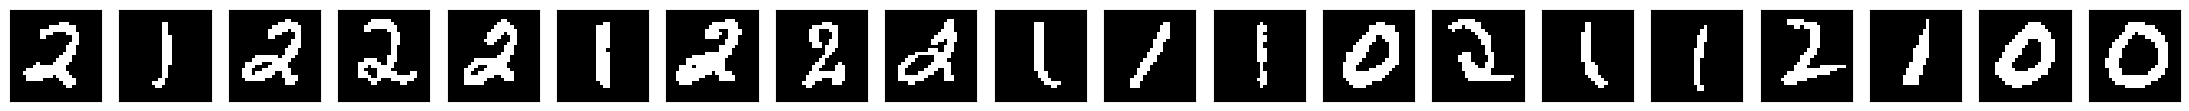

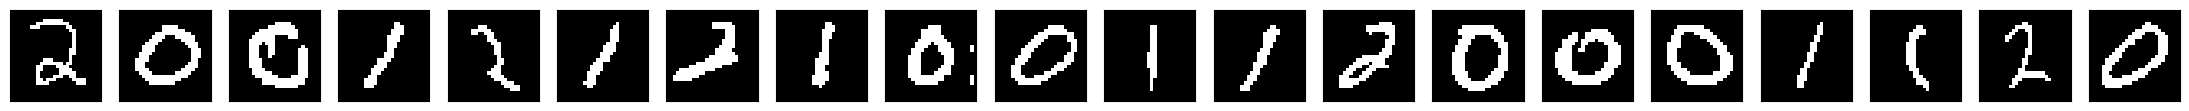

In [11]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 3))
ax.hist( np.sort(label), bins=np.arange(Ndigit + 1) - 1 / 2, density=False, rwidth=0.55, color="g")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8):
   show_MNIST(data[i * 20 :], Nex=20)

In [12]:
def plot_weights_bias(wE, bE, epoch, L, side=0,cols=0,thr=0,s=1.5, title=False, save=True, cmap="bwr"):
   '''
   Plot the weights of the RBM, one plot for each hidden unit.
   '''
   rows = int(np.ceil(L / cols))
   if rows==1: rows=2
   w=wE[epoch]
   b=bE[epoch]
   if side==0: side=int(sqrt(len(w)))
   if thr==0: thr=4
   plt.clf()
   fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
   if title: fig.suptitle(f"epoch = {epoch}")
   k=1
   for i in range(rows):
      for j in range(cols):
         if rows==1: ax=AX[j+1]
         else: ax=AX[i,j+1]
         if k<=L:
               ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
               ax.set_xticks([])
               ax.set_yticks([])
               ax.set_title(f"hidden {k}")
         else: fig.delaxes(ax)
         k+=1
      if i>0:  fig.delaxes(AX[i,0])
   
   ax=AX[0,0];
   im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
   ax.set_xticks([])
   ax.set_yticks([])
   ax.set_title("bias")
   # colobar
   cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
   cbar = fig.colorbar(im, cax=cbar_ax)
   cbar.ax.tick_params(labelsize=12)
   
   S=0.3
   plt.subplots_adjust(hspace=S)

   if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

   plt.show()
   plt.close()


# Load and Save data

In [13]:
#Function to create the name of the file based on their label and hyperparam
def FileName(label, hp, FolderName, KFold = False, index = 0, time = None):
   #Label might be: a, b or w, logL

   fname = f'{FolderName}/{label}_RBM_Ndig{hp['Ndigit']}_L{hp['L']}_Nt{hp['Nt']}_Opt{hp['Opt']}_lrate{hp['l_rate_in']:.4f}-{hp['l_rate_fin']:.4f}_Ep{hp['epochs']}_Mini{hp['mini']}'
   if hp['gamma'] > 0: fname = fname + f'_reg{hp['gamma']:.4f}'
   if hp['POTTS']: fname = fname + f'_MetPOTTS'
   if hp['SPINS']: fname = fname + f'_MetSPINS'
   if hp['POTTS']==False and hp['SPINS']==False: fname = fname + f'_MetBERN'
   fname = fname + f'__{index}'

   if KFold == False:
      fname = fname + f'_{time}' + '.npy'

   return fname

def SaveFile(label, hp, data, FolderName, time, index = 0):
   fname = FileName(label, hp, FolderName, time = time, index = index)

   np.save(fname, data)

In [14]:
#return an array (nummber of trials for the same model) of arrays (these are the numpy arrays of "what" see below)
#what: a,b,w,logL(train),logLvalid
def LoadArrays(what, hp, Folder):

   variable_fileName = FileName(what, hp, FolderName=Folder, index = "*")
   # using * cause we can have more than one file (only difference time when was computed)
   filenames = variable_fileName[:-9] # [:-9] is to delete   _None.npy   at the place of time
   files = sorted(glob.glob(filenames))
   
   arrays = []
   
   for f in files:
      array = np.load(f)
      arrays.append(array)
   return arrays

In [15]:
def LoadData(WhichData = None, WhichFolder = None, WhichModel = None,  KFold = False):

   if KFold == False:
      data_FileList = glob.glob(f"{WhichFolder}/{WhichData}_*") 

      # Load all files into a dictionary
      data = {fname: np.load(fname) for fname in data_FileList}

      #return only the values of the dictionary
      return data
   
   elif KFold:
      dataF = glob.glob(f"{WhichModel}_*") 
      data = [np.load(fname) for fname in dataF]

      #Returns the only element present with the same name
      return data[0]


# 1.Initialization

Explanation of the initialization of the biases

In Restricted Boltzmann Machines (RBMs), visible units can be represented as either Bernoulli (0/1) or Spin (-1/+1).  
To ensure consistent bias initialization across both cases, we normalize the activation proportion $ x_{\text{mean}} $ using:

$$
p_i = \frac{x_{\text{mean}} - x_{\min}}{x_{\max} - x_{\min}}
$$

This transformation ensures that $ p_i $ falls within the probability range $([0,1])$, preventing invalid logarithm calculations.  
The visible biases are then initialized as:

$$
a_i = \frac{1}{\text{level gap}} \log \left( \frac{p_i}{1 - p_i} \right)
$$

where:

$$
\text{level gap} = x_{\max} - x_{\min}
$$

So in the two cases we have
- Bernoulli (0/1):  
  $$
  x_{\min} = 0, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 1
  $$
  $$
  a_i = \log \left( \frac{x_{\text{mean}}}{1 - x_{\text{mean}}} \right)
  $$

- Spin (-1/+1): 
  $$
  x_{\min} = -1, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 2
  $$
  $$
  a_i = \frac{1}{2} \log \left( \frac{x_{\text{mean}} - (-1)}{1 - x_{\text{mean}}} \right)
  $$

  <br>

Given what just said, let's now proceed to explain the reason for this initialization by considering the Bernoulli case (0/1), in which $ a_i = \log \left( \frac{p_i}{1 - p_i} \right)$.

The probability of activation of a visible neuron in an RBM is given by:


$$
P(x_i=1∣h)=σ(a_i+\sum_{j}^{}W_{ij}h_j)
$$

where:

$$
σ(x)=\frac{1}{1+e^{-x}}
$$

If we initialize the weights to small values $( W_{ij} \approx 0 )$, then the activation probability of a visible unit is approximately:

$$
P(x_i = 1) \approx \sigma(a_i)
$$

If we set:

$$
a_i = \log \left( \frac{p_i}{1 - p_i} \right)
$$

then we obtain:

$$
\sigma(a_i) = \frac{1}{1 + e^{-\log \left( \frac{p_i}{1 - p_i} \right) }} = p_i
$$

Thus, the initial probability that the neuron $ i $ is active will be exactly $ p_i $, which corresponds to the frequency with which the neuron is turned on in the training data, so this ensure this is a good initialization choice.

In [16]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"

sigma = sqrt(4. / float(L + D))

### Data inizialization

In [17]:
def InitializeData(Ndigit, KFold = False, SpecificData = None):
   list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
   list_digits = list_10_digits[:Ndigit]
   #print(list_digits)
   keep=np.isin(Y_original, list_digits)
   X_keep,Y=X_original[keep],Y_original[keep]
   data,label = MNIST_bit(X_keep),Y
   data,label = data.astype("int"),label.astype("int")

   if KFold == False:
      return data, label
   
   else:
      return data[SpecificData], label[SpecificData]
      # train, label_train

# 2. Log-likelihood $\mathcal{L}$

### Defining the Log-Likelihood

In [18]:
def log_likelihood_opt(a, b, w, data): # data.shape = (21770, 784), a.shape = (784)
    
    L = len(b)
    D = len(data[0])
    T = len(data)
    q = 1.4
    all_z = np.array(list(itertools.product([0, 1], repeat=L))) # all_z.shape = (2**L, L)

    #We already know the dimension of H
    OnesMat = np.ones(D) #Former was np.ones(len(H))

    E =  np.dot(data, a).reshape(T,1) + np.dot(data, w).dot(all_z.T) + np.dot(all_z, b).reshape(1, 2**L)   # E is a matrix (21770, 2**L)
    first_part = scipy.special.logsumexp(E, axis = 1) # first_part is a vector (21770)

    #                           G(z)                               (1+e^H)/q         
    Z = np.sum(  np.array([ np.exp(np.dot(z, b)) * np.prod( (OnesMat + np.exp( a+np.dot(w, z)))/q ) for z in all_z])  )
    second_part = np.log(Z)+D*np.log(q)

    return np.mean(first_part) - second_part

### Visualization and plots

In [19]:
def plot_LogL_sameHP(all_logL, which_set, epoch_step_ticker=5):

   epoch_used = len(all_logL[0]) #this is the number of epoch used to train
   
   mean_logL = np.mean(all_logL, axis=0)
   std_logL  = np.std(all_logL , axis=0)/np.sqrt(len(all_logL))
   
   fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
   
   x = np.arange(len(mean_logL))
   
   for logL in all_logL:
      ax1.plot(x,logL, alpha = 0.7)
   ax1.set_xlabel('# epoch')
   ax1.set_ylabel(r"$\log \mathcal{L}$")
   ax1.set_title(f'log-Likehood trend on {which_set} set')

   ax2.errorbar(x[0::epoch_step_ticker], mean_logL[0::epoch_step_ticker], yerr=std_logL[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
   ax2.set_xlabel('# epoch')
   ax2.set_ylabel(r"$\log \mathcal{L}$")
   ax2.set_title(f'Average log-Likehood trend on {which_set} set')

   LastPart = 30 #Considering just the last flatten part of the LogL
   End_Part_LogL = mean_logL[-LastPart:]
   Result_LogL = np.full( (LastPart,), np.mean(End_Part_LogL) )
   LLlinspace = np.arange(epoch_used - LastPart, epoch_used, 1)    
   ax2.plot(LLlinspace, Result_LogL, linestyle='dashed', color="red", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
   ax2.fill_between(LLlinspace, Result_LogL - np.std(End_Part_LogL), Result_LogL + np.std(End_Part_LogL), color='red', alpha=0.3, )
   
   ax2.legend(loc='best')

   plt.tight_layout()
   
   plt.show()

In [20]:
def plot_LogL_trainVSvalid(all_logL_train,all_logL_valid,epoch_step_ticker=5):

   num_trials = len(all_logL_train) #this is just the num of k-folds
   x_range = len(all_logL_train[0]) #this is the number of epoch used to train
   mean_logL_train = np.mean(all_logL_train, axis=0)
   std_logL_train  = np.std(all_logL_train , axis=0)/np.sqrt(num_trials)

   mean_logL_valid = np.mean(all_logL_valid, axis=0)
   std_logL_valid  = np.std(all_logL_valid , axis=0)/np.sqrt(num_trials)
   
   fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
   
   x = np.arange(x_range)
   
   ax1.errorbar(x[0::epoch_step_ticker], mean_logL_train[0::epoch_step_ticker], yerr=std_logL_train[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='royalblue',label='train')
   ax1.errorbar(x[0::epoch_step_ticker], mean_logL_valid[0::epoch_step_ticker], yerr=std_logL_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='orangered',label='validation')
   ax1.set_xlabel('# epoch')
   ax1.set_ylabel(r"$\log \mathcal{L}$")
   ax1.set_title('Average log-Likehood trend')
   ax1.legend(loc='best')

   difference = mean_logL_train - mean_logL_valid 
   statistical_error = std_logL_train + std_logL_valid #error's propagation
   ax2.errorbar(x[0::epoch_step_ticker], difference[0::epoch_step_ticker], yerr=statistical_error [0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
   ax2.set_xlabel('# epoch')
   ax2.set_ylabel(r"$\log \mathcal{L}_{train} - \log \mathcal{L}_{validation}$")
   ax2.set_title('Difference logLikehood train - validation')
   ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
   
   plt.tight_layout()
   
   plt.show()

In [21]:
def plot_LogL_model( all_logL_train, all_logL_valid, Nmodel, epoch_step_ticker=5 ):
   num_trials = len(all_logL_train) #this is just the num of k-folds
   epoch_used = len(all_logL_train[0]) #this is the number of epoch used to train
   mean_logL_train = np.mean(all_logL_train, axis=0)
   std_logL_train  = np.std(all_logL_train , axis=0)/np.sqrt(num_trials)

   mean_logL_valid = np.mean(all_logL_valid, axis=0)
   std_logL_valid  = np.std(all_logL_valid , axis=0)/np.sqrt(num_trials)
   
   fig, ax1 = plt.subplots(1,1,figsize=(8, 5))
   
   x = np.arange(epoch_used)
   
   ax1.errorbar(x[0::epoch_step_ticker], mean_logL_train[0::epoch_step_ticker], yerr=std_logL_train[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='blue',label='train', markersize = 4)
   ax1.errorbar(x[0::epoch_step_ticker], mean_logL_valid[0::epoch_step_ticker], yerr=std_logL_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='red',label='validation', markersize = 4)
   ax1.set_xlabel('# epoch')
   ax1.set_ylabel(r"$\log \mathcal{L}$")
   ax1.set_title(f'Average log-Likehood trend for model {Nmodel}')
   ax1.legend(loc='best')
   ax1.grid(True)

   LastPart = 30 #Considering just the last flatten part of the LogL
   End_Part_LogL = mean_logL_valid[-LastPart:]
   Result_LogL = np.full( (LastPart,), np.mean(End_Part_LogL) )
   LLlinspace = np.arange(epoch_used - LastPart, epoch_used, 1)    
   ax1.plot(LLlinspace, Result_LogL, linestyle='dashed', color="green", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
   ax1.fill_between(LLlinspace, Result_LogL - np.std(End_Part_LogL), Result_LogL + np.std(End_Part_LogL), color='green', alpha=0.2, )

   plt.show()

In [22]:
def plot_err_sameHP(all_err, which_set, epoch_step_ticker=5):

   mean_errs = np.mean(all_err, axis=0)
   std_errs = np.std(all_err , axis=0)/np.sqrt(len(all_err))
      
   x = np.arange(len(mean_errs))

   fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
      
   for err in all_err:
      ax1.plot(x,err)
   ax1.set_xlabel('# epoch')
   ax1.set_ylabel("Loss error")
   ax1.set_title(f'Loss error trend on {which_set} set')

   ax2.errorbar(x[0::epoch_step_ticker], mean_errs[0::epoch_step_ticker], yerr=std_errs[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
   ax2.set_xlabel('# epoch')
   ax2.set_ylabel("Average loss error")
   ax2.set_title(f'Average error trend on {which_set} set')
   
   plt.tight_layout()
   
   plt.show()

In [23]:
def plot_err_trainVSvalid(all_err_train,all_err_valid,epoch_step_ticker=5):

   num_trials = len(all_err_train) #this is just the k-folds
   x_range = len(all_err_train[0]) #this is the number of epoch used to train
   
   mean_err_train = np.mean(all_err_train, axis=0)
   std_err_train  = np.std(all_err_train , axis=0)/np.sqrt(num_trials)

   mean_err_valid = np.mean(all_err_valid, axis=0)
   std_err_valid  = np.std(all_err_valid , axis=0)/np.sqrt(num_trials)
   
   fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5))
   
   x = np.arange(x_range)
   
   ax1.errorbar(x[0::epoch_step_ticker], mean_err_train[0::epoch_step_ticker], yerr=std_err_train[0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='blue',label='train')
   ax1.errorbar(x[0::epoch_step_ticker], mean_err_valid[0::epoch_step_ticker], yerr=std_err_valid[0::epoch_step_ticker], linestyle='-', marker='o', capsize=3, color='red',label='validation')
   ax1.set_xlabel('# epoch')
   ax1.set_ylabel("Loss error")
   ax1.set_title('Average error trend')
   ax1.legend(loc='best')

   difference = mean_err_train - mean_err_valid 
   statistical_error = std_err_train + std_err_valid #rule for statistica uncertanties propagation
   ax2.errorbar(x[0::epoch_step_ticker], difference[0::epoch_step_ticker], yerr=statistical_error [0::epoch_step_ticker], linestyle='--', marker='o', capsize=3, color='steelblue')
   ax2.set_xlabel('# epoch')
   ax2.set_ylabel("Loss error difference")
   ax2.set_title('Difference loss train - validation')
   ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
   
   plt.tight_layout()
   
   plt.show()

# B. Setting the Restricted Boltzmann Machine

### Contrastive Divergence (CD)

In [24]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

### RBM Train function

In [34]:
#'FolderName' is the folder in which we want to save the file: SingleTrain for this, BM_RandomSearch for the random search

def train_RBM(Hyperparams, FolderName, Debug = False, LL = True, LLPlot = False, BoolSaveFile = True, index=0, KFold = False, Train_I = None, Valid_I = None): 

   #Only to check if the directory FolderName exist
   if os.path.isdir(FolderName):

      Ndigit = Hyperparams['Ndigit']
   
      L = Hyperparams['L']
      Nepoch = Hyperparams['epochs']
      Nt = Hyperparams['Nt']
      gamma = Hyperparams['gamma']
      l_rate_ini, l_rate_fin = Hyperparams['l_rate_in'], Hyperparams['l_rate_fin']
      GRAD = Hyperparams['Opt']
      POTTS, SPINS = Hyperparams['POTTS'], Hyperparams['SPINS']

      log_L_list = []

      # minibatches per epoch
      Nmini = Hyperparams['mini']
      # minibatch size at initial epoch and final one
      N_ini, N_fin= 40, 400

      data, label = InitializeData(Ndigit, KFold, Train_I)

      # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
      w = sigma * np.random.randn(D,L)
      #a = sigma * np.random.randn(D)
      # using Hinton initialization of visible biases
      a = Hinton_bias_init(data)
      # hidden biases initialized to zero
      b = np.zeros(L)

      # recording history of weights ("E" means epoch)
      wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
      wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
      gwE,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
      gaE,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
      gbE,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
      miniE = np.zeros(Nepoch+1)
      pzE=np.zeros((Nepoch+1,Nz))
      

      if GRAD=="RMSprop": 
         gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
         beta,epsilon=0.9,1e-4 #From original notebook, when setting Gradient descent

      indices=np.arange(len(data)).astype("int")

      if Debug:
         plot_weights_bias(wE, aE, 0, L, cols=6, save=False)

      if Debug:
         if POTTS: print("Starting the training, POTTS=True")

      # Note: here an epoch does not analyze the whole dataset
      for epoch in tqdm.tqdm(range(1,Nepoch+1)):
         # q maps epochs to interval [0,1]
         q = (epoch-1.)/(Nepoch-1.) 
         # N, size of the mini batch
         # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
         N = int(N_ini + (N_fin-N_ini)*(q**2))
         #  l_rate interpolates between initial and final value
         l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

         selected = np.random.choice(indices, N, replace=False)

         for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)

            for k in range(N):
               ###################################
               x0 = data[selected[k]]
               # positive CD phase: generating z from x[k]
               
               z = CD_step(x0,w,b,POTTS=POTTS)
               x_data  += x0
               z_data  += z
               xz_data += np.outer(x0,z)
               # fantasy
               zf=np.copy(z)
               # Contrastive divergence with Nt steps
               for t in range(Nt):
                  # negative CD pzase: generating fantasy xf from fantasy zf
                  xf = CD_step(zf,w.T,a)
                  # positive CD phase: generating fantasy zf from fantasy xf 
                  zf = CD_step(xf,w,b,POTTS=POTTS)
               x_model += xf
               z_model += zf
               xz_model+= np.outer(xf,zf)
               # recording probability of encoding in z-space, if POTTS
               if POTTS:
                   pz[zf]+=1
               ###################################
           
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)


            # gradient ascent step
            if GRAD=="RMSprop":
               # RMSprop gradient ascent
               gw2 = beta*gw2+(1-beta)*np.square(gw)
               ga2 = beta*ga2+(1-beta)*np.square(ga)
               gb2 = beta*gb2+(1-beta)*np.square(gb)
               w += l_rate*gw/sqrt(epsilon+gw2)
               a += l_rate*ga/sqrt(epsilon+ga2)
               b += l_rate*gb/sqrt(epsilon+gb2)

            else: 
               # defaulting to the vanilla stochastic gradient ascent (SGD)
               w += l_rate*gw
               a += l_rate*ga
               b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
               w -= (gamma*l_rate)*sign(w)
               a -= (gamma*l_rate)*sign(a)
               b -= (gamma*l_rate)*sign(b)

         wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
         aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
         bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
         miniE[epoch]=N

         #Computing the likelihood
         if LL:
            log_L = log_likelihood_opt(a, b, w, data)
            log_L_list.append(log_L)


         if POTTS: pzE[epoch] = pz/np.sum(pz)
      
         str_time = datetime.datetime.now().strftime("_%m%d_%H%M")

      if Debug:
         plot_weights_bias(wE, aE, epoch, L, cols=6, save=False)


      if BoolSaveFile:
         SaveFile('w', Hyperparams, wE, FolderName, time = str_time, index=index)
         SaveFile('b', Hyperparams, bE, FolderName, time = str_time, index=index)
         SaveFile('a', Hyperparams, aE, FolderName, time = str_time, index=index)
         if LL :
            SaveFile('logL', Hyperparams, log_L_list, FolderName, time = str_time, index=index)
          

      if LLPlot:

         LogLike = log_L_list[-30:]

         #To have an array of the same dimension of x
         MeanLL = np.full((30,), np.mean(LogLike))

         LLlinspace = np.arange(Nepoch - 30, Nepoch, 1)

         plt.figure(figsize=(10, 6))
         plt.plot(range(Nepoch), log_L_list, label=r"$\log \mathcal{L}$")
         plt.plot(LLlinspace, MeanLL, linestyle='dashed', color="red", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
         plt.fill_between(LLlinspace, MeanLL - np.std(LogLike), MeanLL + np.std(LogLike), color='red', alpha=0.3, )

         plt.title("log-Likehood trend")  # Titolo
         plt.xlabel("# epoch")  # Etichetta asse X
         plt.ylabel(r"$\log \mathcal{L}$")  # Etichetta asse Y
         plt.grid(True)  # Aggiunge una griglia
         plt.legend()
         plt.show()

      if LL:
         return np.mean(log_L_list[-30:]),  np.std(log_L_list[-30:])

   else:
      print("Directory does not exist")

### KFold function

In [26]:
from sklearn.model_selection import KFold

def KFold_SingleModel(data, hp, num_k_folds , FolderToSave):

   KFolds = KFold(n_splits = num_k_folds, shuffle=True)

   All_LL_train = []
   All_LL_valid = []
    
   # (train_I, test_I) contains 
   for i, (train_I, valid_I) in enumerate(KFolds.split(data)):

      #Train the kfold model with the train data
      train_RBM(hp, FolderName=FolderToSave, Debug = False, LLPlot = False, LL = True, BoolSaveFile=True, index=i, KFold=True, Train_I = train_I, Valid_I=valid_I)

      a_fileName = FileName('a', hp, FolderName=FolderToSave, KFold=True, index = i)
      b_fileName = FileName('b', hp, FolderName=FolderToSave, KFold=True, index = i)
      w_fileName = FileName('w', hp, FolderName=FolderToSave, KFold=True, index = i)
      logL_fileName = FileName('logL', hp, FolderName=FolderToSave, KFold=True, index = i)
   
      #Load the file
      a_data = LoadData(WhichFolder = FolderToSave, WhichModel = a_fileName, KFold = True)
      b_data = LoadData(WhichFolder = FolderToSave, WhichModel = b_fileName, KFold = True)
      w_data = LoadData(WhichFolder = FolderToSave, WhichModel = w_fileName, KFold = True)

      str_time = datetime.datetime.now().strftime("_%m%d_%H%M")
      #Load the file and compute the log validation
      logL_train = LoadData(WhichFolder = FolderToSave, WhichModel = logL_fileName, KFold = True)
      logL_Valid = [ log_likelihood_opt(a_data[epoch], b_data[epoch], w_data[epoch], data[valid_I]) for epoch in range(hp['epochs']) ]
      SaveFile('logLvalid', hp, logL_Valid, FolderToSave, time = str_time, index=i)



      All_LL_valid.append(logL_Valid)
      All_LL_train.append(logL_train)

   return np.array(All_LL_train), np.array(All_LL_valid)

# Training of a simple model

We now train a model with some default hyperparameters. After the training we compute the KFold and then visualize the trend of the log-likelihood of the training and validation

{'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


<Figure size 640x480 with 0 Axes>

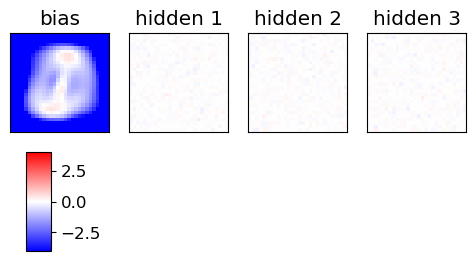

100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


<Figure size 640x480 with 0 Axes>

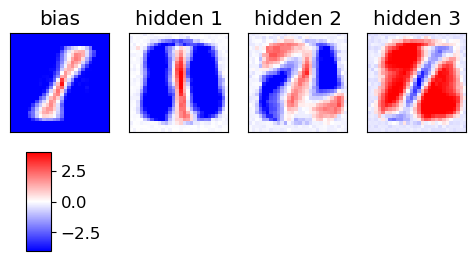

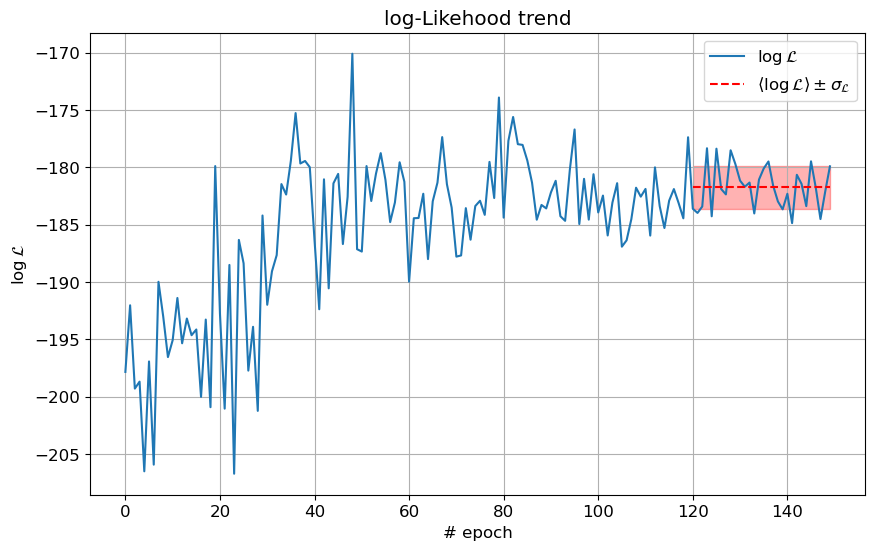

In [120]:
DefaultHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}
print(DefaultHyperp)
train_RBM(DefaultHyperp, FolderName = Folder1, Debug = True, LL = True, LLPlot=True, BoolSaveFile=True)

In [121]:
#PERFORM THE K-FOLD
logLtrain_arrays, logLvalid_arrays = KFold_SingleModel(data, DefaultHyperp, num_k_folds = 3, FolderToSave = Folder2)

100%|██████████| 150/150 [01:03<00:00,  2.35it/s]


In [ ]:
#USE THIS WHEN K FOLDS IS ALREADY STORED
# logLtrain_arrays = LoadArrays('logL', DefaultHyperp, Folder2)
# logLvalid_arrays = LoadArrays('logLvalid', DefaultHyperp, Folder2)

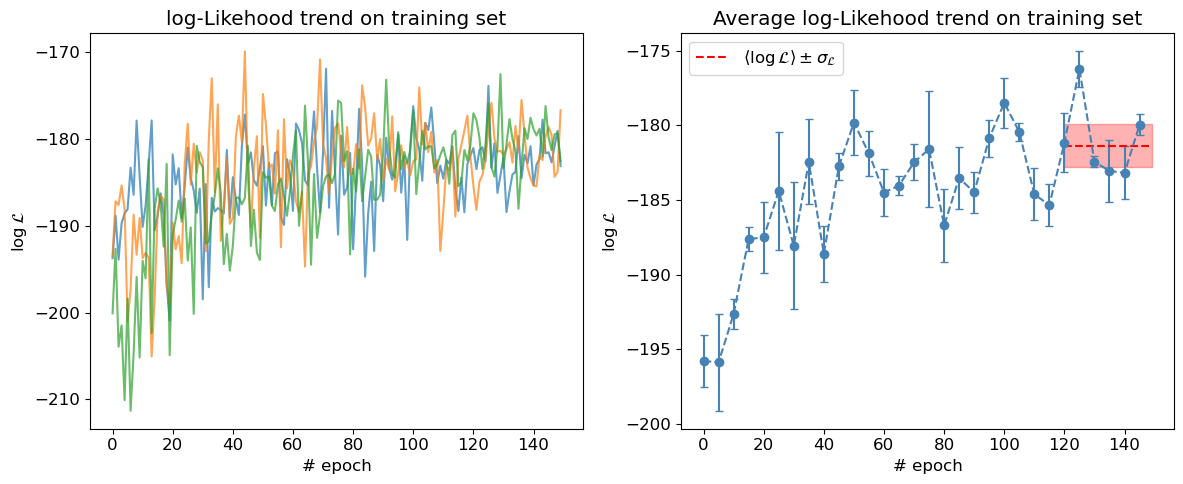

In [160]:
plot_LogL_sameHP(logLtrain_arrays, "training", epoch_step_ticker=5)

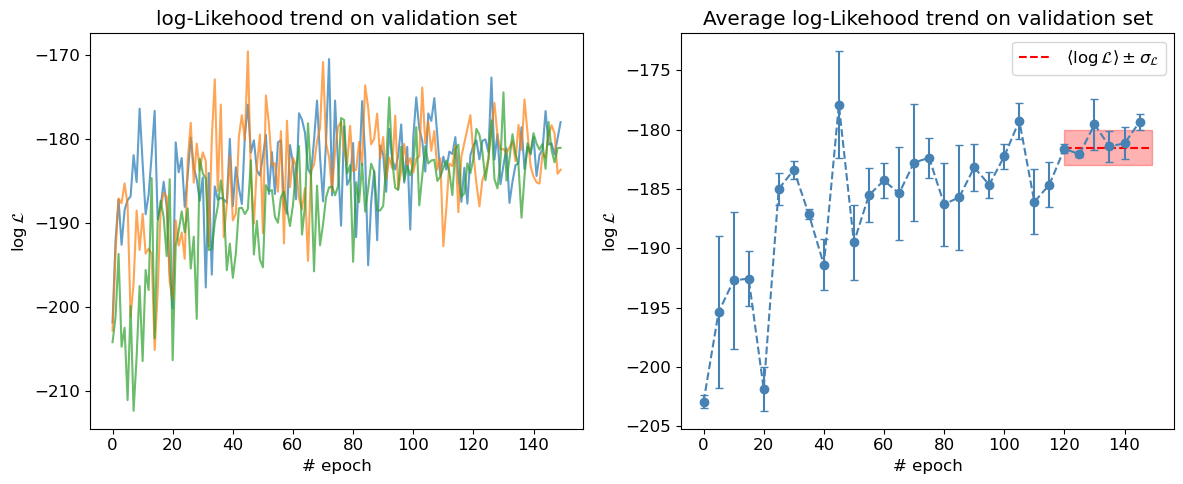

In [161]:
plot_LogL_sameHP(logLvalid_arrays, "validation", epoch_step_ticker=5)

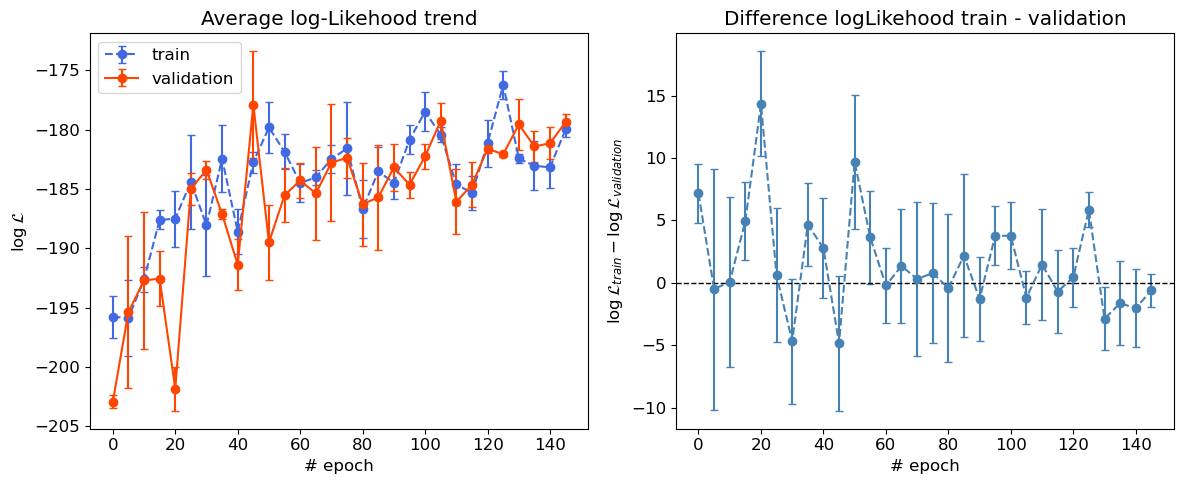

In [162]:
plot_LogL_trainVSvalid(logLtrain_arrays, logLvalid_arrays, epoch_step_ticker=5)

## Verify how $\mathcal{L}$ changes with L and CD 

It seems that more complex models tends to have better results. The number of contrastive divergence seems also to have a relevant impact in the final result.

In [ ]:
#Same model as before
TestHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 
                 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

L_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Nt_range = [13, 14]


#Run time: 6hr

#Commented because it take too long
TestLogLik, stdLL = np.zeros((len(L_range), len(Nt_range))), np.zeros((len(L_range), len(Nt_range)))

for i, l in enumerate(L_range):
   for j, nt in enumerate(Nt_range):
      TestHyperp.update({'L': l, 'Nt': nt})
      print(TestHyperp)
      LLMean, LLstd = train_RBM(TestHyperp, 'TestTrain', Debug = False, LL = True, LLPlot = False, BoolSaveFile=True)

      print((LLMean, LLstd))
      TestLogLik[i][j] = LLMean
      stdLL[i][j] = LLstd

      np.save('MoreColumnmean.npy', TestLogLik)
      np.save('MoreColumnstd.npy', stdLL)

In [61]:
TestLogLik = np.load('TestLLmean1.npy')
stdLL = np.load('TestLLstd1.npy')

MoreTestLogLik = np.load('MoreColumnmean.npy')
MorestdLL = np.load('MoreColumnstd.npy')

MoreTestLogLik

array([[-195.5441, -194.9985],
       [-180.6587, -181.6995],
       [-183.2253, -183.7554],
       [-175.7155, -177.9941],
       [-172.0789, -172.3066],
       [-169.5206, -168.738 ],
       [-171.5239, -178.0456],
       [-164.5257, -166.9233],
       [-172.3705, -166.5452],
       [-166.9456, -162.2193],
       [-160.7275, -157.2458],
       [-150.5327, -154.8118]])

In [ ]:
# test = np.concatenate((TestLogLik, MoreTestLogLik), axis = 1)
# testSTD = np.concatenate((stdLL, MorestdLL), axis = 1)

# test


# np.save('TestLLmean2.npy', test)
# np.save('TestLLstd2.npy', testSTD)

testSTD= np.load('TestLLstd2.npy')


testSTD

NameError: name 'TestLogLik' is not defined

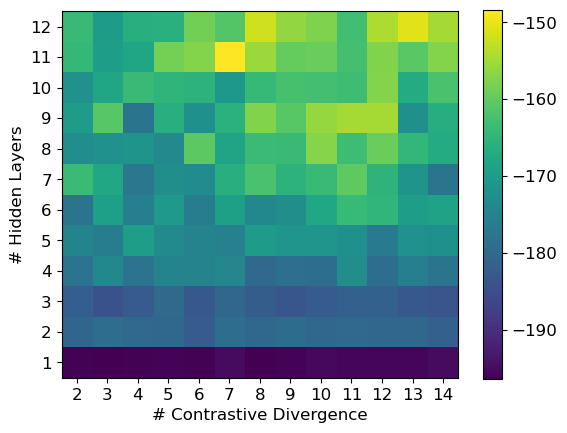

In [7]:
L_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Nt_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

TestLLmean = np.load('TestLLmean2.npy')
testSTD= np.load('TestLLstd2.npy')


#plt.figure(figsize=(8, 8))
plt.imshow(TestLLmean)
plt.gca().invert_yaxis()
plt.colorbar()

x, y = np.meshgrid(np.arange(2), np.arange(2))
#plt.scatter(x, y, color='white', s=10)  # Small dots at each point
#plt.errorbar(x.ravel(), y.ravel(), yerr=testSTD.ravel(), fmt='none', ecolor='white', alpha=0.8)
plt.xticks(ticks=np.arange(0, len(Nt_range)), labels=np.arange(2, len(Nt_range) + 2))
plt.yticks(ticks=np.arange(0, len(L_range)), labels=np.arange(1, len(L_range) + 1))
plt.xlabel("# Contrastive Divergence")
plt.ylabel("# Hidden Layers")

plt.show()

# 3. Hyperparameters and RandomSearch

We now implement a random search algorithm in order to find the best hyperparameters for the RBM

In [ ]:
HP_range = {'Ndig': 3,
      'L': [3, 6], 
      'Nt': [2, 6], 
      'Opt': ['RMSprop'],
      'l_rate_in': [1, 0.1], 
      'l_rate_fin': [0.1, 0.05],  'mini': [10, 41],'gamma': [0.1, 0.001],'epochs' : 150}
      #'BERN','POTTS','SPINS' is decided inside the RandomSearch function}

def RandomSearch(HP_range, nModels):

   HyperParams_List = []

   for _ in range(nModels):

      Ndigit = HP_range['Ndig']
      L = np.random.randint(HP_range['L'][0], HP_range['L'][1])
      Nt = np.random.randint(HP_range['Nt'][0], HP_range['Nt'][1] )
      l_rate_in = np.round(np.random.uniform(HP_range['l_rate_in'][0], HP_range['l_rate_in'][1]), 4)
      l_rate_fin = np.round(np.random.uniform(HP_range['l_rate_fin'][0], HP_range['l_rate_fin'][1]), 4)
      mini = np.random.choice(range(HP_range['mini'][0], HP_range['mini'][1], 5))
      gamma = np.round(np.random.uniform(HP_range['gamma'][0], HP_range['gamma'][1]), 4)
      epochs = HP_range['epochs']
      Opt = np.random.choice(HP_range['Opt'])
      Met = np.random.choice(['BERN','POTTS','SPINS'])

      HyperParams = {'Ndigit': Ndigit, 'L': L, 'Nt': Nt, 'Opt': Opt, 'l_rate_in': l_rate_in, 
                     'l_rate_fin': l_rate_fin, 'epochs': epochs, 'mini': mini, 'gamma': gamma, 'POTTS': False, 'SPINS': False}

      if Met == 'BERN':
            HyperParams['POTTS'] = False
            HyperParams['SPINS'] = False
      # if Met == 'POTTS':
      #       HyperParams['POTTS'] = True
      #       HyperParams['SPINS'] = False
      # if Met == 'SPINS':
      #       HyperParams['POTTS'] = False
      #       HyperParams['SPINS'] = True

      HyperParams_List.append(HyperParams)

   return HyperParams_List

### Ad now we train all the RBM with the different hyperparameters 

In [65]:
HyperParam_List = np.array( RandomSearch(HP_range, nModels = 2))
HyperParam_List #to check everything is fine

array([{'Ndigit': 3, 'L': 4, 'Nt': 5, 'Opt': 'RMSprop', 'l_rate_in': 0.9968, 'l_rate_fin': 0.0868, 'epochs': 150, 'mini': 25, 'gamma': 0.0917, 'POTTS': False, 'SPINS': False},
       {'Ndigit': 3, 'L': 4, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.6329, 'l_rate_fin': 0.0767, 'epochs': 150, 'mini': 20, 'gamma': 0.0646, 'POTTS': False, 'SPINS': False}],
      dtype=object)

In [ ]:
def KFoldRandomSearch(HyperParam_List, num_k_folds = 4, NameOfFile = 'test2'):

   ModelsLogsL = [] #e.g. [ modelA(arrays_logLtrain, arrays_logLvalidation) , modelB(arrays_logLtrain, arrays_logLvalidation) ]
   ListOfModelsAndResults = {}


   for hp in HyperParam_List:
      print(hp)
      arrays_logLtrain, arrays_logLvalidation = KFold_SingleModel(data, hp, num_k_folds=num_k_folds, FolderToSave=Folder3)
      ModelsLogsL.append( (arrays_logLtrain, arrays_logLvalidation) )



   LastPartLogL = 30 #taking just the last numbers of data from the logLvalidation
   ResultModels = [] #this has tuples of (mean,std) considering just the "LastPartLogL" number of data, where logL flattens
   for LogsL_train, LogsL_valid in ModelsLogsL:
      mean_LogL_valid = np.mean(LogsL_valid, axis=0)
      ResultModels.append ((np.mean(mean_LogL_valid[ -LastPartLogL: ]) , np.std(mean_LogL_valid[ -LastPartLogL: ])))



   #needed cause later we'll sort them
   ModelsLogsL = np.array(ModelsLogsL)
   ResultModels = np.array(ResultModels)


   for i in range(len(HyperParam_List)):
      ListOfModelsAndResults[f'{HyperParam_List[i]}'] = [ModelsLogsL[i], ResultModels[i]]

   np.save(f'{NameOfFile}', ListOfModelsAndResults)

   #return ListOfModelsAndResults

In [68]:
#Running the RandomSearch on multiple computers to have a fair amount of models to compare
KFoldRandomSearch(HyperParam_List, 2)

{'Ndigit': 3, 'L': 4, 'Nt': 5, 'Opt': 'RMSprop', 'l_rate_in': 0.9968, 'l_rate_fin': 0.0868, 'epochs': 150, 'mini': 25, 'gamma': 0.0917, 'POTTS': False, 'SPINS': False}


100%|██████████| 150/150 [01:54<00:00,  1.31it/s]


{'Ndigit': 3, 'L': 4, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.6329, 'l_rate_fin': 0.0767, 'epochs': 150, 'mini': 20, 'gamma': 0.0646, 'POTTS': False, 'SPINS': False}


100%|██████████| 150/150 [01:23<00:00,  1.79it/s]


In [ ]:
# RaffaeleFile = np.load('RaffaeleFile.npy', allow_pickle=True).item()
# NicoloFile = np.load('NicoloFile1.npy', allow_pickle=True).item()
# NicoloFile2 = np.load('NicoloFile2.npy', allow_pickle=True).item()
# NicoloFile3 = np.load('NicoloFile3.npy', allow_pickle=True).item()
# FrancescoFile = np.load('FrancescoFile.npy', allow_pickle=True).item()
# MarcoFile = np.load('MarcoFile.npy', allow_pickle=True).item()

In [ ]:
def LoadFileAndAsList(Dictionary):

   Hyperpar_List = [ast.literal_eval(key) for key in Dictionary.keys()]
   Result_Mod = [list(Dictionary.values())[i][1] for i in range(len(list(Dictionary.values())))]
   ModelsLogL = [list(Dictionary.values())[i][0] for i in range(len(list(Dictionary.values())))]

   return np.array(Hyperpar_List), np.array(Result_Mod), np.array(ModelsLogL)

In [ ]:
# HyperParam_List1, ResultModels1, ModelsLogsL1 = LoadFileAndAsList(NicoloFile2)
# HyperParam_List2, ResultModels2, ModelsLogsL2 = LoadFileAndAsList(NicoloFile)
# HyperParam_List3, ResultModels3, ModelsLogsL3 = LoadFileAndAsList(FrancescoFile)
# HyperParam_List4, ResultModels4, ModelsLogsL4 = LoadFileAndAsList(RaffaeleFile)
# HyperParam_List5, ResultModels5, ModelsLogsL5 = LoadFileAndAsList(MarcoFile)
# HyperParam_List6, ResultModels6, ModelsLogsL6 = LoadFileAndAsList(NicoloFile3)



# HyperParam_List = np.concatenate((HyperParam_List1, HyperParam_List2, HyperParam_List3, HyperParam_List4, HyperParam_List5, HyperParam_List6))
# ResultModels = np.concatenate((ResultModels1, ResultModels2, ResultModels3, ResultModels4, ResultModels5, ResultModels6))
# ModelsLogsL = np.concatenate((ModelsLogsL1, ModelsLogsL2, ModelsLogsL3, ModelsLogsL4, ModelsLogsL5, ModelsLogsL6))

# np.save('HyperParam_List', HyperParam_List)
# np.save('ResultModels', ResultModels)
# np.save('ModelsLogsL', ModelsLogsL)

#Loading and saving all the files

In [241]:
#Load all the models:
HyperParam_List = np.load('HyperParam_List.npy', allow_pickle=True)
ResultModels = np.load('ResultModels.npy', allow_pickle=True)
ModelsLogsL = np.load('ModelsLogsL.npy', allow_pickle=True)

In [242]:
#Function to order all the model just found from the best one to the worst one
def OrderingModels(HyperParam_List, ResultModels, ModelsLogsL):
    sorted_indices = sorted(range(len(ResultModels)), key=lambda i: ResultModels[i][0], reverse=True) 
    return HyperParam_List[sorted_indices] , ResultModels[sorted_indices], ModelsLogsL[sorted_indices]

In [243]:
#Ordering the models according to the results
HyperParam_List, ResultModels, ModelsLogsL = OrderingModels(HyperParam_List, ResultModels, ModelsLogsL )

TopModels  = 2 #decide how many model to take
TopHP      = list(HyperParam_List[:-5])
TopResults = list(ResultModels[:-5])

#DataFrame to visualize the results
df = pd.DataFrame(TopHP)
df.index = [ f'Model {i+1}' for i in range(len(TopHP))] 
df[r"$\langle\mathcal{\log L}\rangle$"] = [res[0] for res in TopResults] #Final mean LogL
df[r"$\sigma_{\mathcal{L}}$"] = [res[1] for res in TopResults] #Final std LogL

# Display DataFrame with all the models
df

,Ndigit,L,Nt,Opt,l_rate_in,l_rate_fin,epochs,mini,gamma,POTTS,SPINS,$\langle\mathcal{\log L}\rangle$,$\sigma_{\mathcal{L}}$
Model 1,3,5,4,RMSprop,0.1165,0.0528,150,15,0.0252,False,False,-174.300104,2.737694
Model 2,3,5,4,RMSprop,0.1606,0.0520,150,35,0.0048,False,False,-175.623225,2.198905
Model 3,3,5,3,RMSprop,0.5573,0.0775,150,25,0.0676,False,False,-177.066964,2.220422
Model 4,3,5,4,RMSprop,0.6371,0.0795,150,40,0.0040,False,False,-177.147694,2.093080
Model 5,3,5,5,RMSprop,0.9332,0.0546,150,40,0.0552,False,False,-177.178082,2.794352
Model 6,3,5,4,RMSprop,0.4997,0.0567,150,15,0.0178,False,True,-177.575787,2.411110
Model 7,3,5,3,RMSprop,0.9736,0.0672,150,30,0.0177,False,False,-177.603665,2.174912
Model 8,3,5,3,RMSprop,0.4816,0.0586,150,10,0.0814,False,True,-177.934271,1.453294
Model 9,3,5,4,RMSprop,0.7178,0.0503,150,25,0.0483,False,False,-178.266795,2.323193
Model 10,3,4,5,RMSprop,0.1885,0.0589,150,30,0.0278,False,True,-178.983104,2.232178


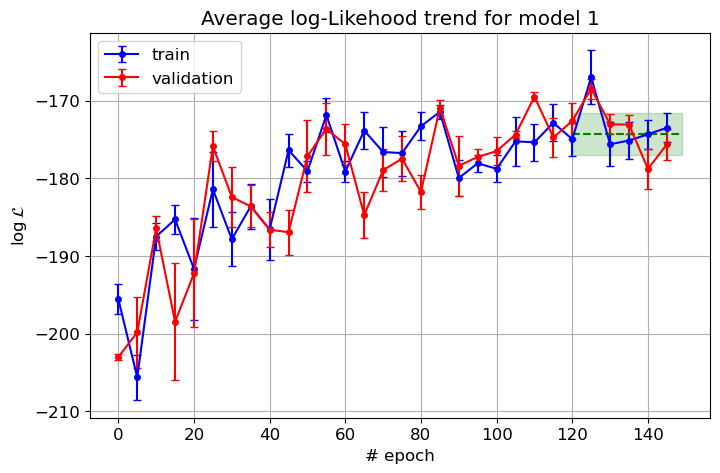

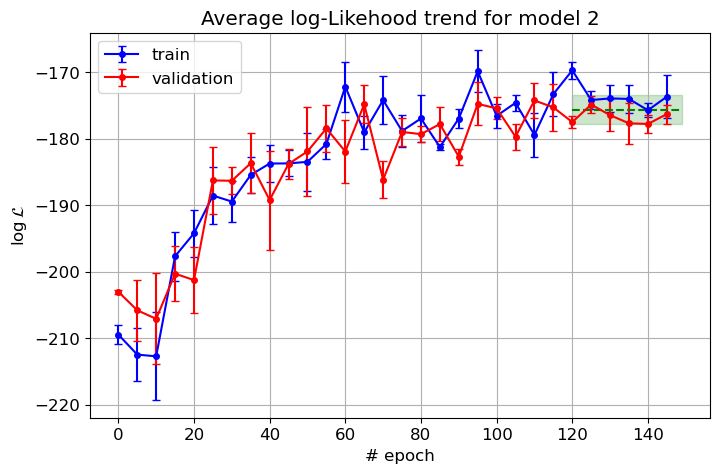

In [244]:
#Visualizing the first two best models
for i in range(TopModels):
   plot_LogL_model( ModelsLogsL[i][0], ModelsLogsL[i][1], Nmodel=i+1, epoch_step_ticker=5 ) 

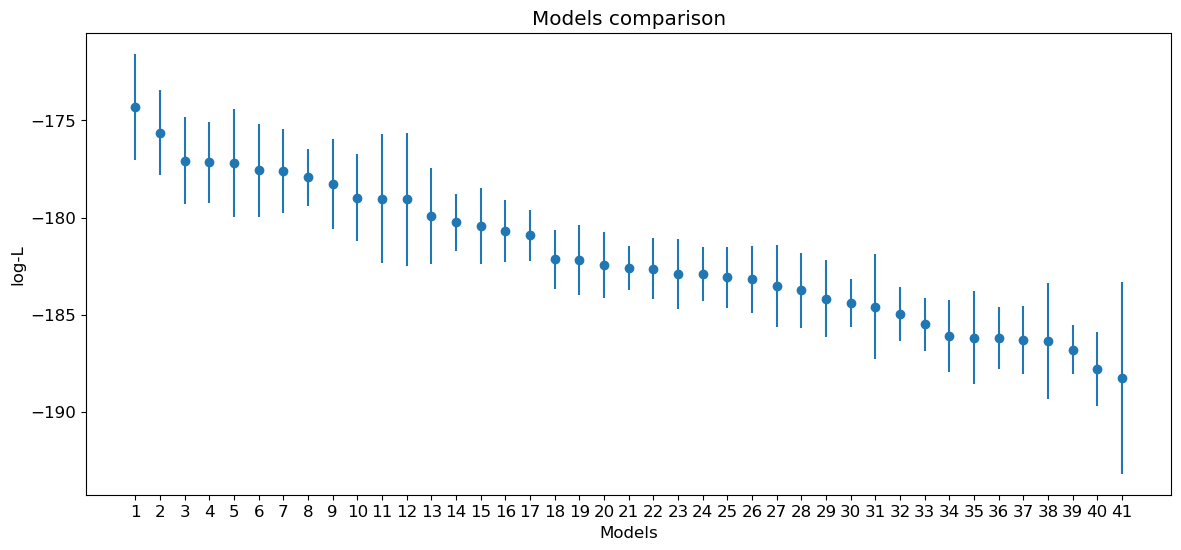

In [245]:
#Visualization of the results of all model
x = np.arange(len(HyperParam_List[:-5]))
y = [t[0] for t in TopResults]
erry = [t[1] for t in TopResults]


plt.figure(figsize=(14, 6))
plt.errorbar(x, y, yerr = erry, fmt='o')
plt.ylabel("log-L")
plt.xlabel("Models")
plt.title("Models comparison")
plt.xticks(ticks=np.arange(0, len(x)), labels=np.arange(1, len(x)+1))

plt.show()

# Generating power of the best model

<Figure size 640x480 with 0 Axes>

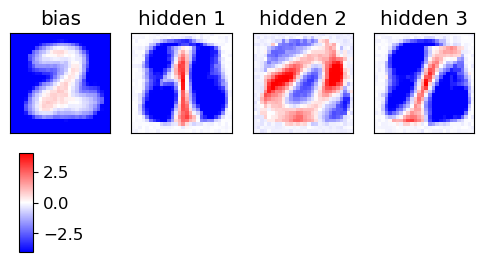

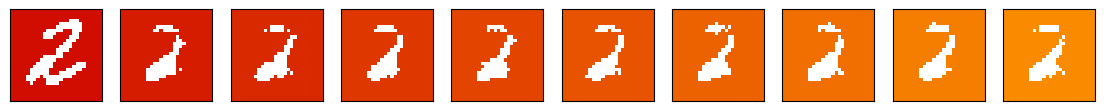

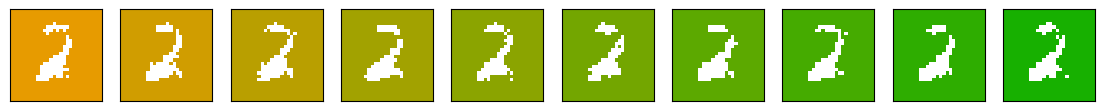

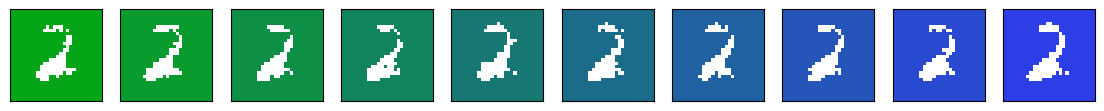

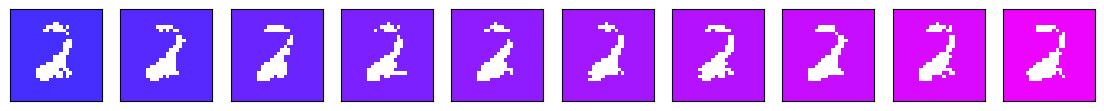

L: 3     amplification of weights: 10.0


In [246]:
#To be changed with the parameters of the best model
aE = np.load('SimpleTrain/a_RBM_Ndig3_L3_Nt2_OptRMSprop_lrate0.05-0.05_Ep150_Mini20_reg0.001_MetBERN__0__0321_2117.npy')
bE = np.load('SimpleTrain/b_RBM_Ndig3_L3_Nt2_OptRMSprop_lrate0.05-0.05_Ep150_Mini20_reg0.001_MetBERN__0__0321_2117.npy')
wE = np.load('SimpleTrain/w_RBM_Ndig3_L3_Nt2_OptRMSprop_lrate0.05-0.05_Ep150_Mini20_reg0.001_MetBERN__0__0321_2117.npy')

ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=10.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)

plot_weights_bias(wE, aE, 150, L, cols=3, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF )

# 4. Hidden state activation

We want now to visualize the distribution of the activated hidden states. We firstly visualize for a simple RMB with just 3 digits (0, 1, 2) and only 3 hidden states. Then we visualize the same distribution but with all 10 numbers from the MNIST and 5 hidden states

In [247]:
def HiddenStateAct(Nc, HyperP, aE, bE, wE, xAxis, ImSize, showGlobalHist = False):

    Ndigit = HyperP['Ndigit']
    L = HyperP['L']

    nRows = int(np.floor(Ndigit/3)*2) if showGlobalHist and Ndigit <= 3 else int(np.ceil(Ndigit/3))
    data, label = InitializeData(Ndigit)

    digits = [data[label == i] for i in range(Ndigit)] # "shape" (Ndigit, Ndata, 784)
    fig, axes = plt.subplots(nRows, 3, figsize=ImSize)

    z_Nf_freq = [] # z_Nf_freq has shape (N_digits, 2**L, L)

    states = list(map(lambda s: str(s).replace(",", "").replace("(", "[").replace(")", "]"), itertools.product([0, 1], repeat=L)))  # I need [0 0 0] format goddammit

    units_freq = np.zeros((Ndigit, L)) # each element is an array of frequencies for each unit composing the hidden state of dim. L

    # generalize to arbitrary number of plots

    for i in range(Ndigit):
        # x_cd = np.zeros((Nc, len(digits[i]), L))
        x_f = digits[i]          # shape (N, 784)
        z_cd = np.zeros((Nc, len(digits[i]), L))

        for j in range(Nc):
            z_cd[j] = [CD_step(digit, wE[-1], bE[-1]) for digit in x_f]
            x_f     = [CD_step(zeta, wE[-1].T, aE[-1]) for zeta in z_cd[j]]

        z_Nf_activated = [str(state).replace(".", "") for state in z_cd[-1]]

        z_Nf_occurrences = Counter(z_Nf_activated) # {(0,0,1): 4, (1,0,1): 10, ...}
        
        single_digit_frequencies = [z_Nf_occurrences[state] for state in states]
        z_Nf_freq.append(single_digit_frequencies)

        units_freq[i] = np.sum(z_cd[-1], axis=0)

    #####################################################
    # VISUALIZATION
    #####################################################

    if Ndigit > 3:
        digit = 0
        for t in range(nRows):
            for k in range(3):
                if (t*3)+k == Ndigit: break
                #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
                axes[t][k].bar(states, z_Nf_freq[(t*3)+k], fill=False, hatch='/', edgecolor='orange', label=f'Activated at step {Nc}')

                if xAxis == False: 
                    axes[t][k].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axes[t][k].title.set_text(f"Digit {digit} activated states")
                axes[t][k].legend()
                axes[t][k].set_xlabel("Possible States")
                axes[t][k].set_ylabel("Counts")

                digit += 1

    elif Ndigit <= 3 and showGlobalHist:

        units = ['$Z_1$', '$Z_2$', '$Z_3$']

        for i in range(3):
            #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
            axes[0][i].bar(states, z_Nf_freq[i], fill=False, hatch='/', edgecolor='orange', label= f'States activated at step {Nc}' if Nc > 1 else "States activated by images")
            axes[1][i].bar(units, units_freq[i], fill=False, hatch='/', edgecolor='blue', label= f'Units activated at step {Nc}' if Nc > 1 else "Units activated by images")
            
            for t in range(nRows):

                if xAxis == False: 
                    axes[t][i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axes[t][i].title.set_text(f"Digit {i}")
                axes[t][i].legend()
                axes[t][i].set_xlabel("Possible States")
                axes[t][i].set_ylabel("Counts")

    else:

        for i in range(3):
            #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
            axes[i].bar(states, z_Nf_freq[0][i], fill=False, hatch='/', edgecolor='orange', label= f'States activated at step {Nc}' if Nc > 1 else "States activated by images")

            if xAxis == False: 
                axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

            axes[i].title.set_text(f"Digit {i}")
            axes[i].legend()
            axes[i].set_xlabel("Possible States")
            axes[i].set_ylabel("Counts")

    fig.tight_layout()  # Automatically adjusts spacing
    plt.show()
    plt.close()

In [ ]:
#Training a simple model
HiddenStateActHyperP1 = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

#train_RBM(HiddenStateActHyperP1, FolderName=Folder1, Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

100%|██████████| 150/150 [00:45<00:00,  3.30it/s]


<Figure size 640x480 with 0 Axes>

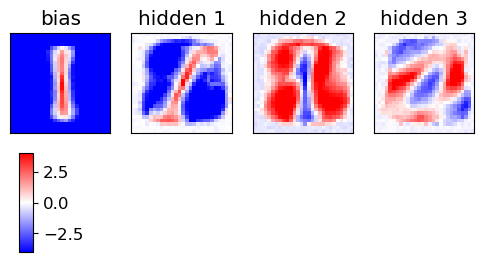

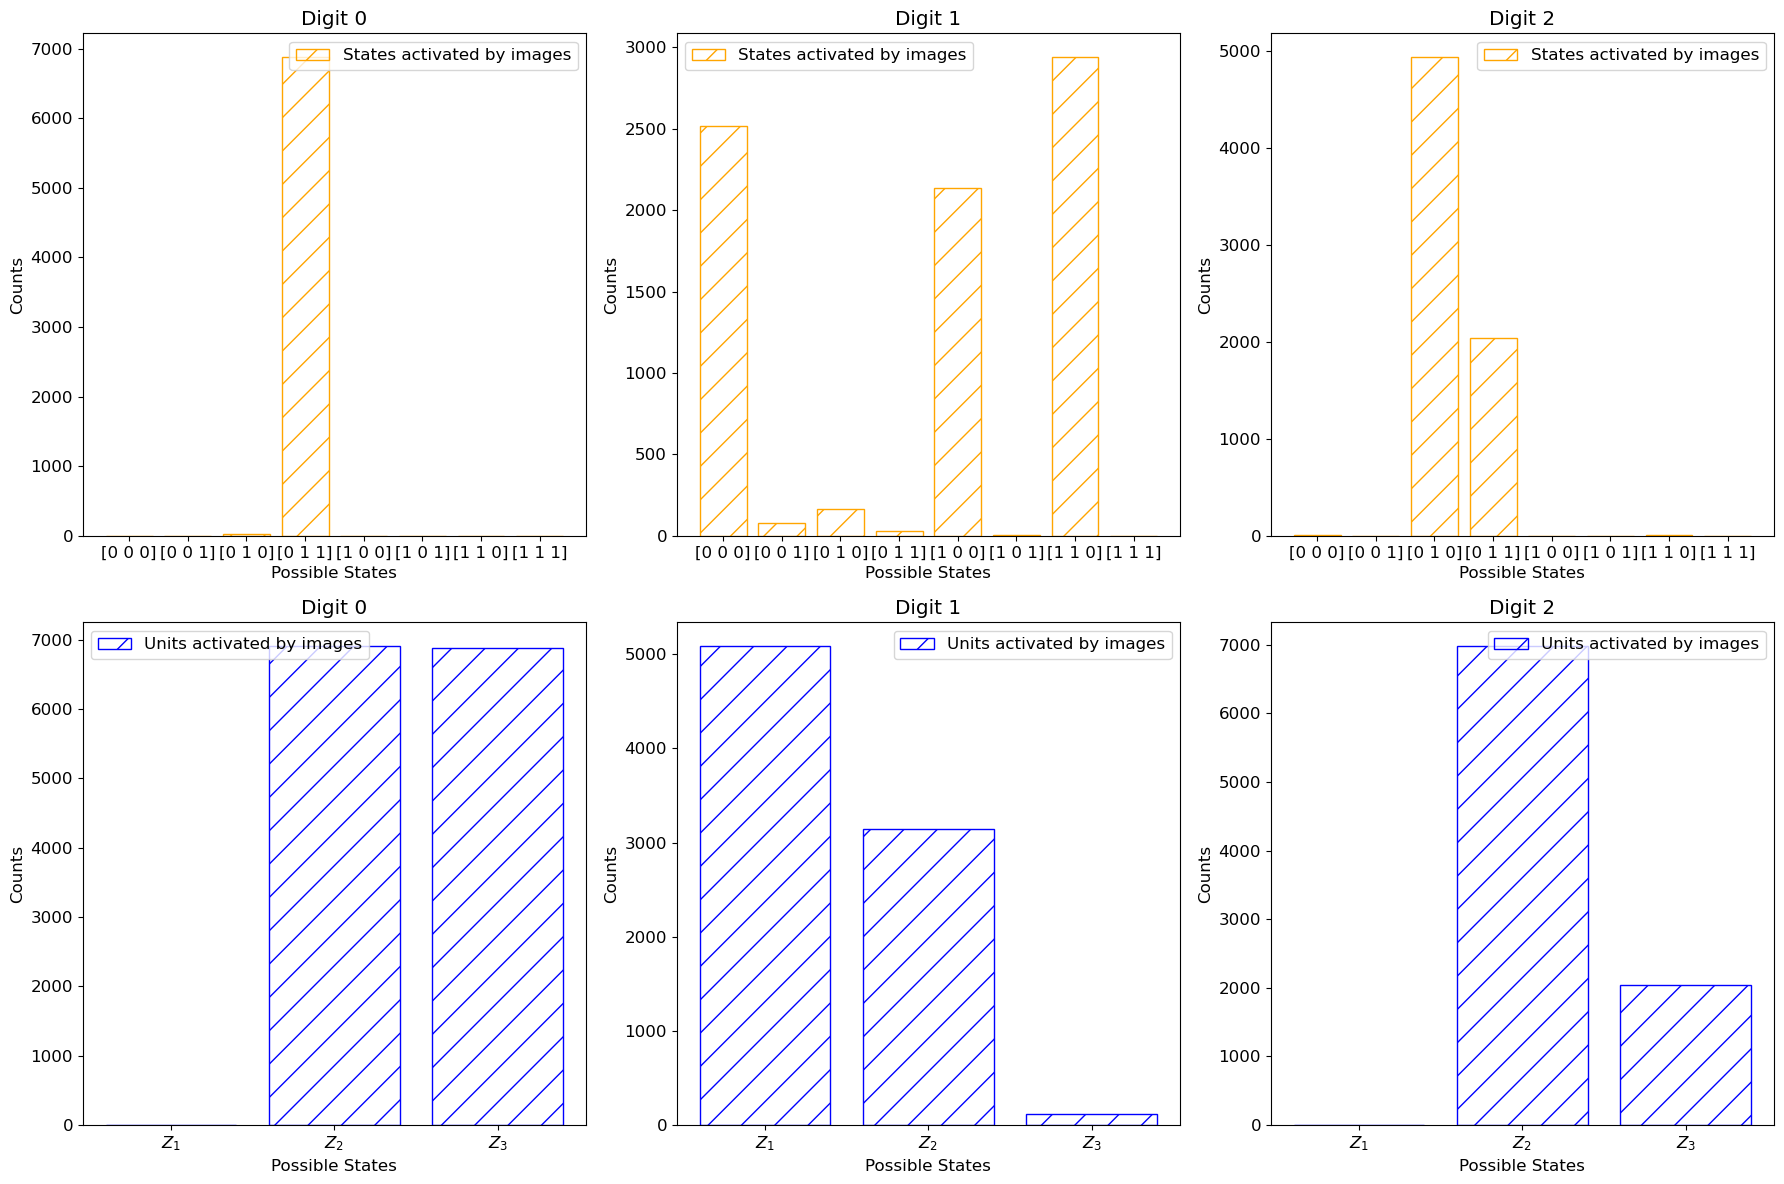

In [251]:
#once you have the hyperparameters dictionarys (i.e. HiddenStateActHyperP1) should be easy
#se function    LoadArrays(what, hp, Folder)    in LoadData section
aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

plot_weights_bias(wE, aE, 150, 3, cols=3, save=False)
HiddenStateAct(1, HiddenStateActHyperP1, aE, bE, wE, xAxis = True, ImSize = (18, 12), showGlobalHist=True)

In [220]:
HiddenStateActHyperP2 = {'Ndigit': 9, 'L': 10, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

train_RBM(HiddenStateActHyperP2, FolderName=Folder1, Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

100%|██████████| 150/150 [00:51<00:00,  2.94it/s]


<Figure size 640x480 with 0 Axes>

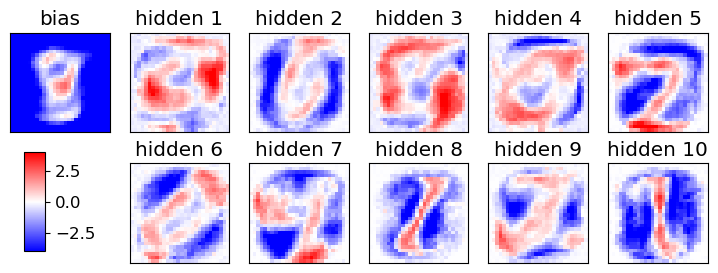

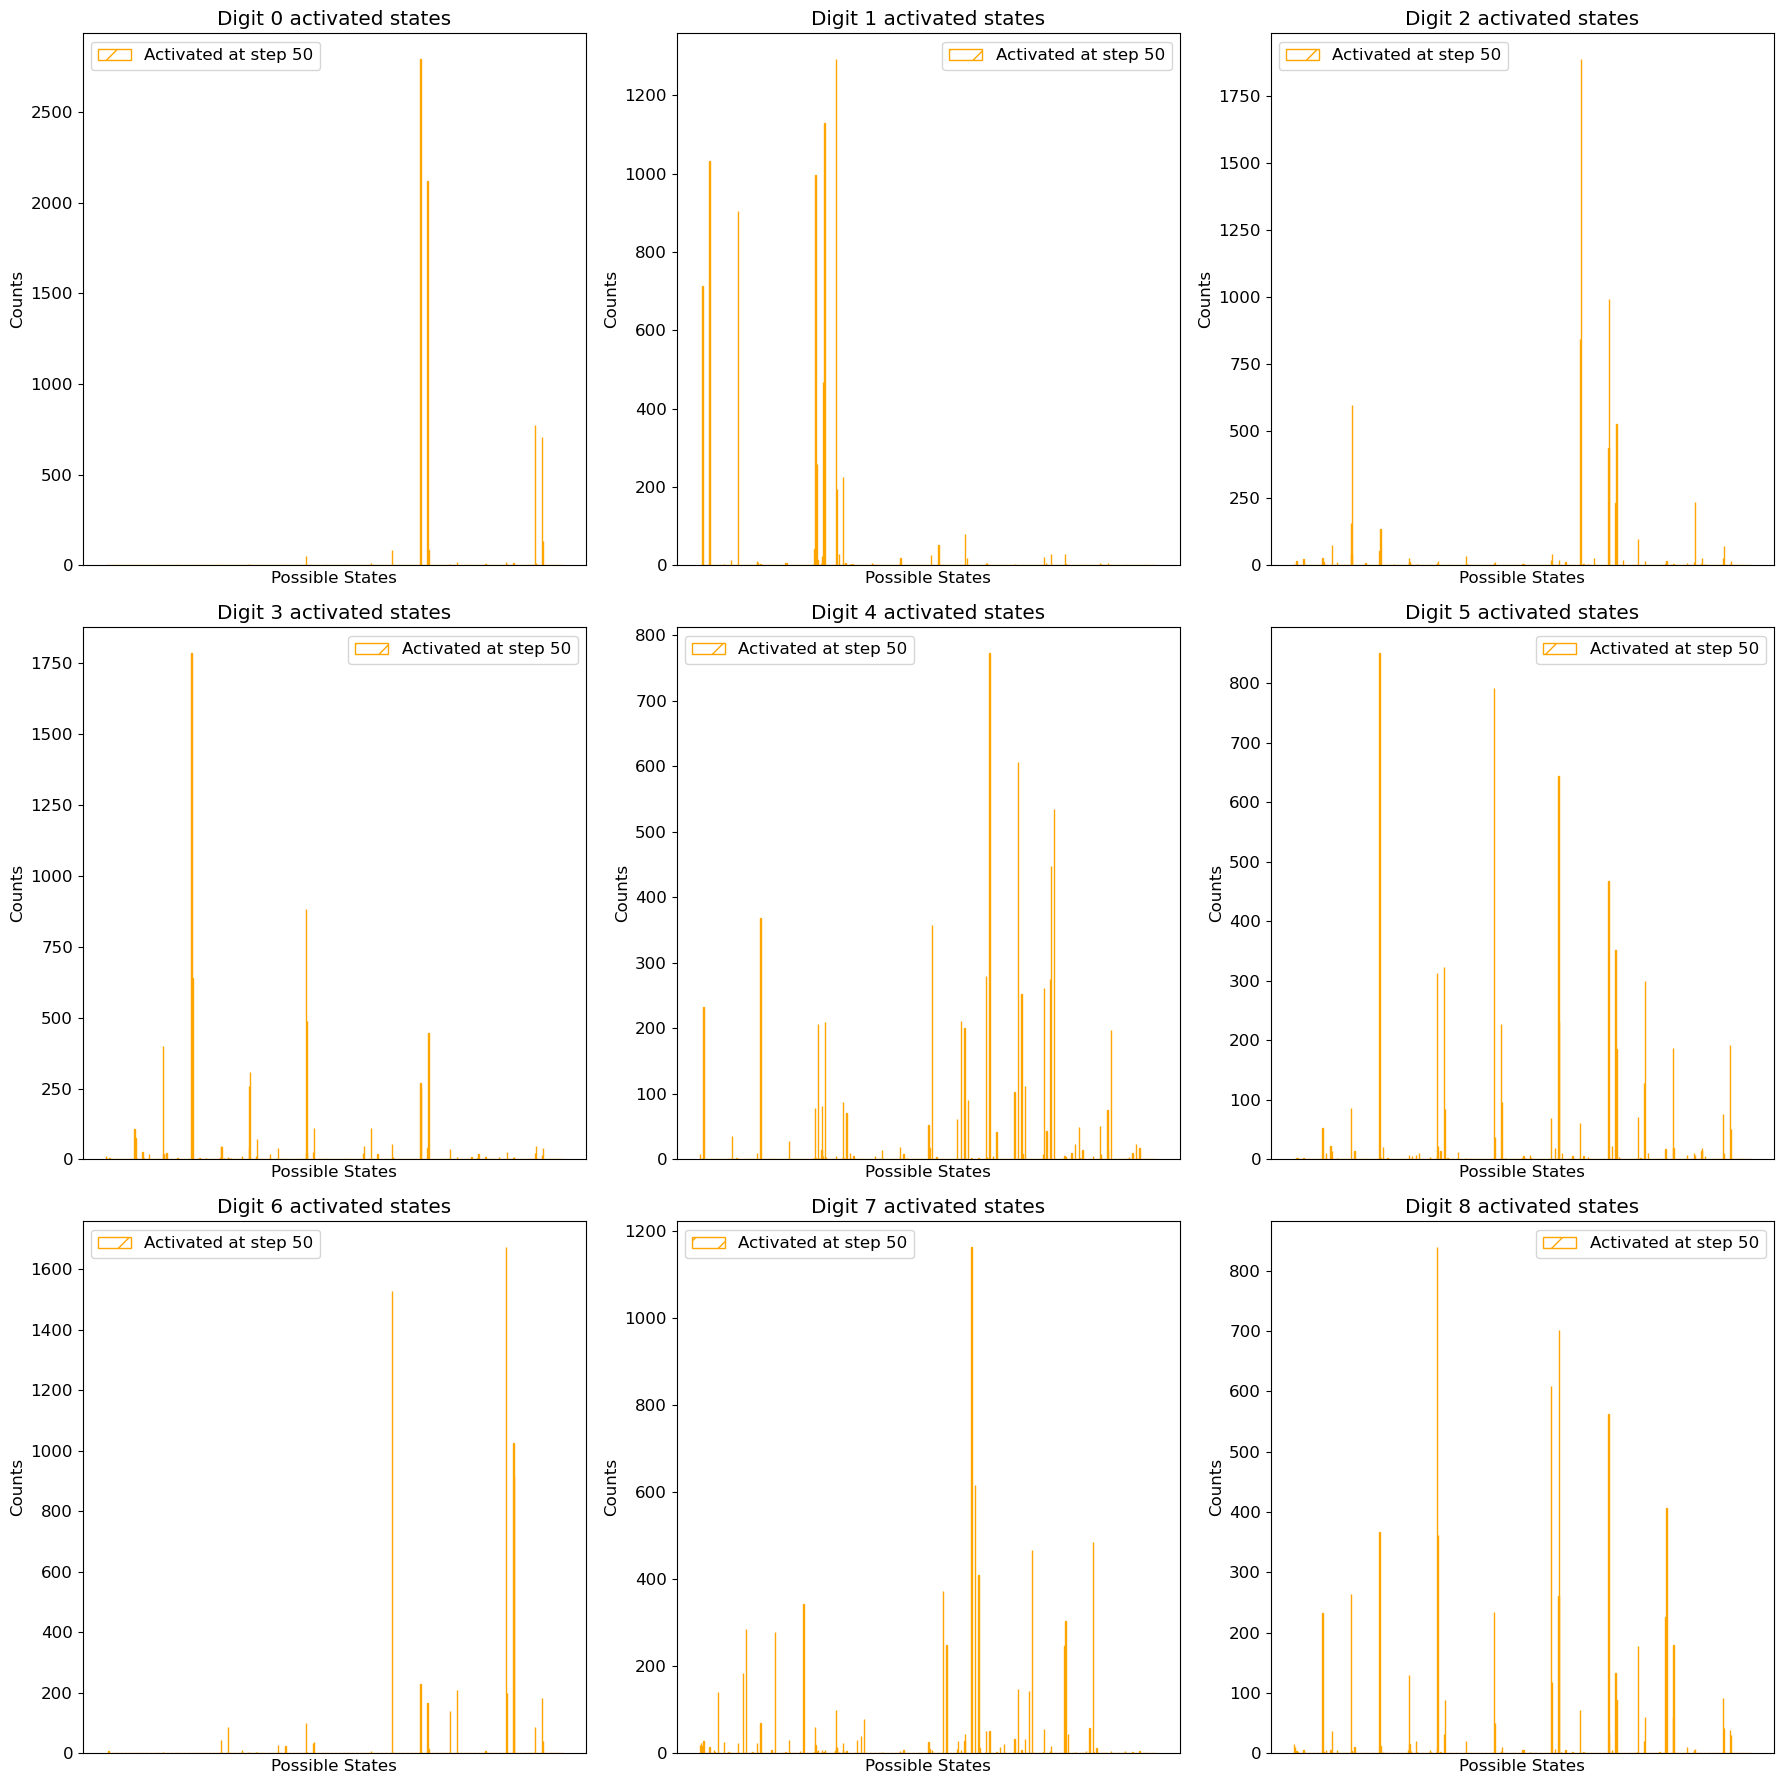

In [222]:
#same as before see loaddata section LoadArrays(what, hp, Folder)
aE = np.load('TestTrain/a_RBM_Ndig9_L10_Nt2_OptRMSprop_lrate0.0500-0.0500_Ep150_Mini20_reg0.0010_MetBERN__0__0322_1028.npy')
bE = np.load('TestTrain/b_RBM_Ndig9_L10_Nt2_OptRMSprop_lrate0.0500-0.0500_Ep150_Mini20_reg0.0010_MetBERN__0__0322_1028.npy')
wE = np.load('TestTrain/w_RBM_Ndig9_L10_Nt2_OptRMSprop_lrate0.0500-0.0500_Ep150_Mini20_reg0.0010_MetBERN__0__0322_1028.npy')

plot_weights_bias(wE, aE, 150, 10, cols=5, save=False)
HiddenStateAct(50, HiddenStateActHyperP2, aE, bE, wE, xAxis = False, ImSize = (18, 18))

# 5. Energy barriers

In [252]:
def EnergyBarrier(aE, bE, wE, ShowBarrier):
    W = wE[-1]
    a = aE[-1]
    b = bE[-1]

    selectA = 1
    selectB = 2
    index_selectA = np.random.choice( np.where(label == selectA)[0] )
    index_selectB = np.random.choice( np.where(label == selectB)[0] )
    dataA = data[index_selectA]
    dataB = data[index_selectB]

    zA = CD_step(dataA,W,b)
    zB = CD_step(dataB,W,b)

    def energy(x, z, W, a, b):
        return -(np.dot(x, a) + np.dot(z, b) + np.dot(x, np.dot(W , z)))

    n_steps = 150
    energies = []
    intermediate_images = []

    for alpha in np.linspace(0, 1, n_steps):

        if ShowBarrier:
            # PART SHOW BARRIER
            x_intermediate = (1 - alpha) * dataA + alpha * dataB  # Interpolazione lineare
            x_intermediate = (x_intermediate > 0.5).astype(int)  # Soglia binaria
            z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))
            # ----------------------

        else:
            # PART OVERCOME BARRIER
            x_intermediate = np.zeros(D)
            #ora per ogni pixel, decido con la soglia random se prendere il valore da dataA o da dataB
            for i in range(D):
                if np.random.uniform() > alpha:
                    x_intermediate[i] = dataA[i]
                else:
                    x_intermediate[i] = dataB[i]

                z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))



    plt.figure(figsize=(8, 4))
    plt.plot(range(n_steps), energies, marker='o')
    if ShowBarrier: plt.xlabel(f"Linear transition between {selectA} and {selectB}")
    else: plt.xlabel(f"Random transition between {selectA} and {selectB}")
    plt.ylabel("Energy")
    plt.title(f"Energetic barrier between {selectA} and {selectB}")
    plt.grid()
    plt.show()

    # show some intermediate step
    show_inter_steps = 5
    fig, axes = plt.subplots(1, show_inter_steps, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(intermediate_images[i * (n_steps // show_inter_steps)], cmap='gray')
        ax.axis('off')
    plt.show()
    

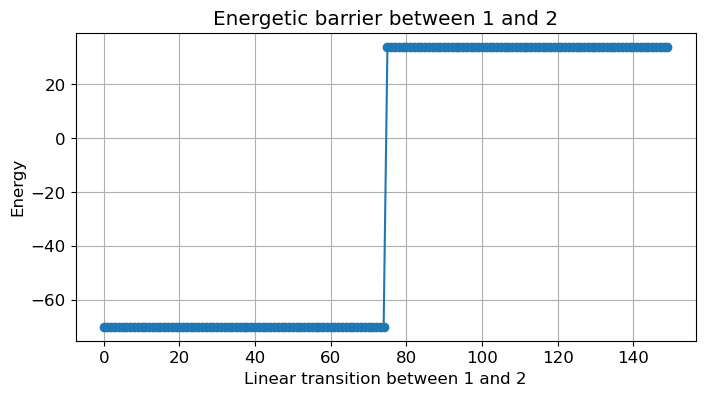

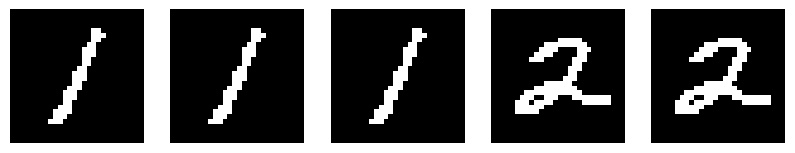

In [253]:
aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

EnergyBarrier(aE, bE, wE, ShowBarrier=True)

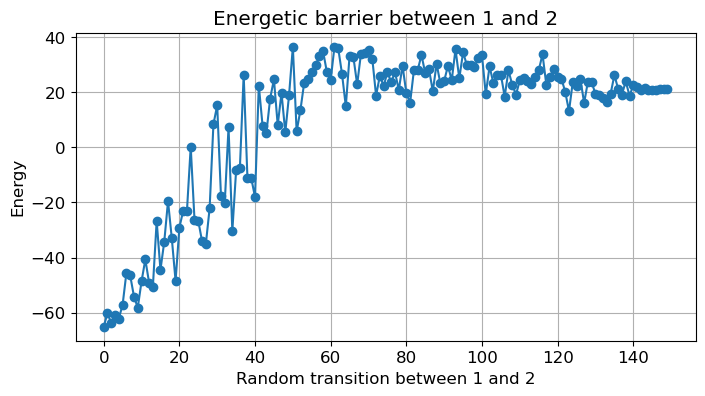

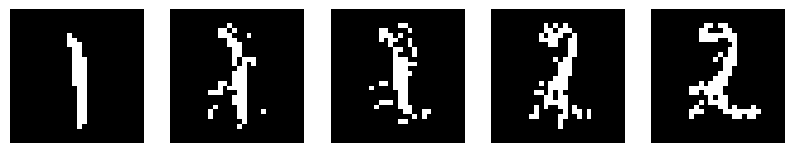

In [254]:
EnergyBarrier(aE, bE, wE, ShowBarrier=False)